# cis-sQTL analysis
After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot


- Intron annotation: GTEx and Leafviz 

In [1]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
setwd("~/project-gandalm/isoform_twas/sqtl_new/")

### 1: Optimal number of HCP

HCP,Count
<dbl>,<int>
5,86146
10,89726
15,91373
20,91911
25,92221
30,92567
35,92868
40,92743
45,92713


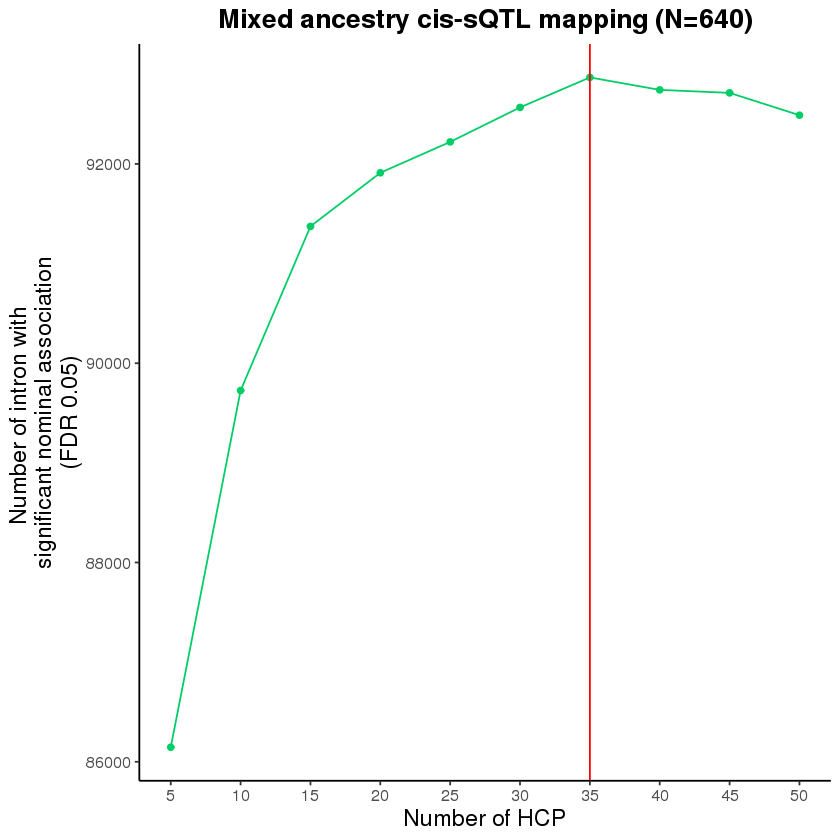

In [5]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}
df

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "springgreen3") +
    geom_line(aes(x=HCP, y=Count), color = "springgreen3") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 35, color = "red") +
    labs(title = "Mixed ancestry cis-sQTL mapping (N=640)",
         x = "Number of HCP",
         y = "Number of intron with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [8]:
ggsave("figures/mixed_nominal.png", p1, width = 6, height = 6)

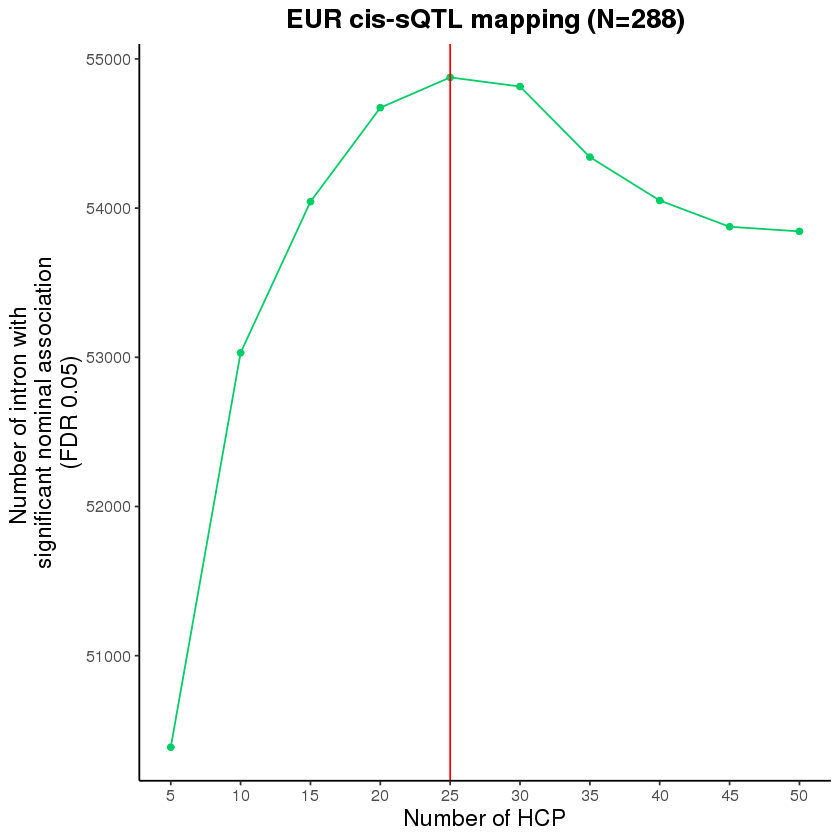

In [4]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "springgreen3") +
    geom_line(aes(x=HCP, y=Count), color = "springgreen3") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 25, color = "red") +
    labs(title = "EUR cis-sQTL mapping (N=288)",
         x = "Number of HCP",
         y = "Number of intron with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [5]:
ggsave("figures/eur_nominal.png", p1, width = 6, height = 6)

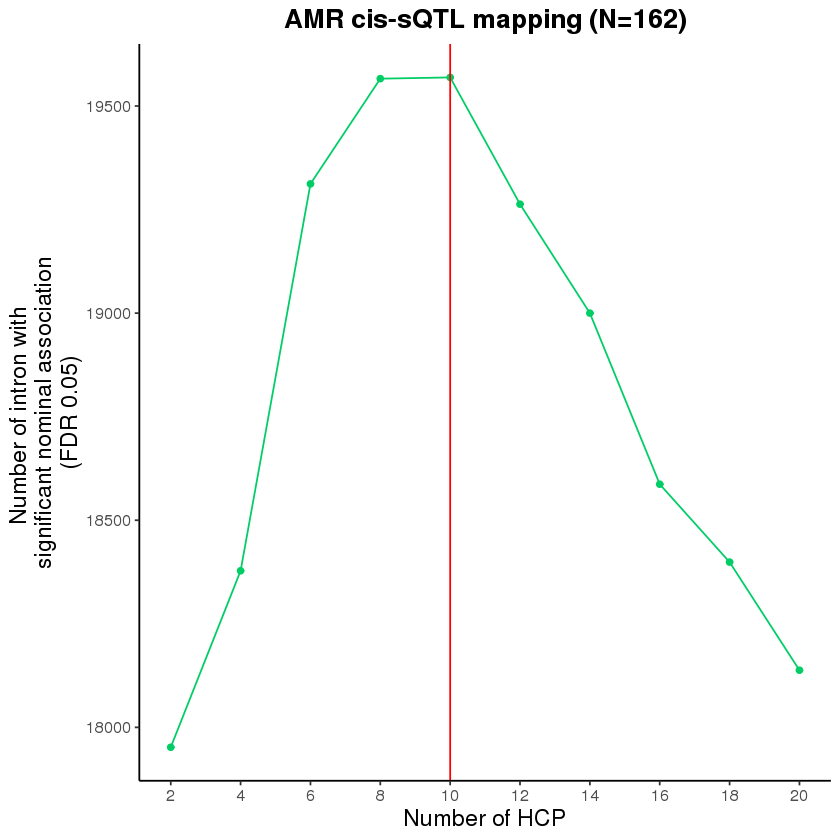

In [10]:
df <- data.frame("HCP" = seq(2, 20, 2),
                 "Count" = NA)
for (i in seq(2, 20, 2)) {
    df[i/2, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "springgreen3") +
    geom_line(aes(x=HCP, y=Count), color = "springgreen3") +
    scale_x_continuous(breaks = seq(0,22,by = 2)) +
    geom_vline(xintercept = 10, color = "red") +
    labs(title = "AMR cis-sQTL mapping (N=162)",
         x = "Number of HCP",
         y = "Number of intron with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [11]:
ggsave("figures/amr_nominal.png", p1, width = 6, height = 6)

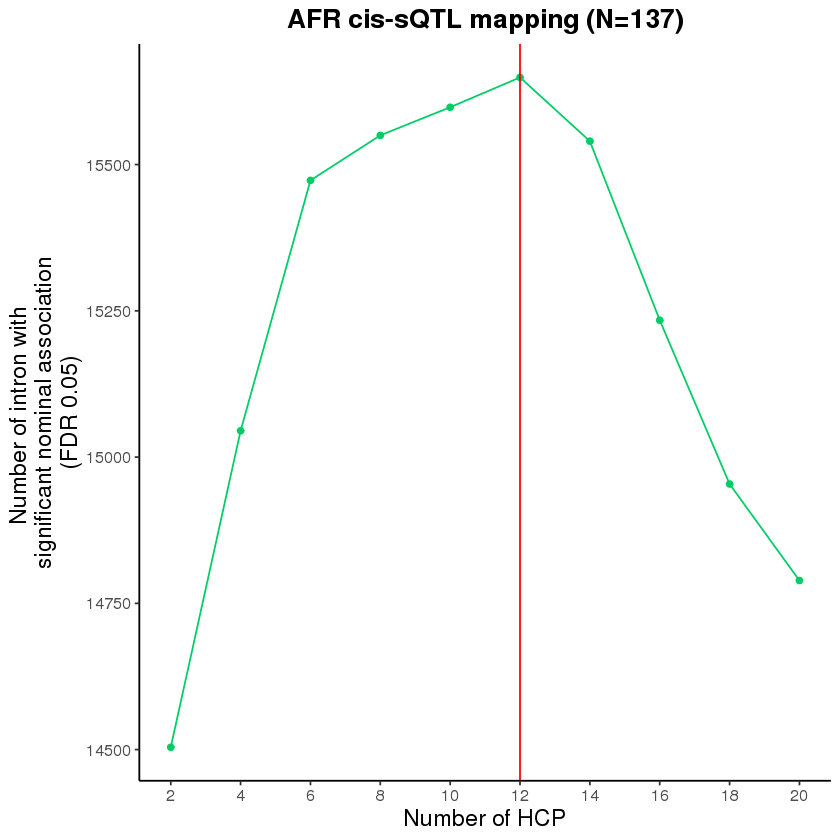

In [3]:
df <- data.frame("HCP" = seq(2, 20, 2),
                 "Count" = NA)
for (i in seq(2, 20, 2)) {
    df[i/2, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "springgreen3") +
    geom_line(aes(x=HCP, y=Count), color = "springgreen3") +
    scale_x_continuous(breaks = seq(0,22,by = 2)) +
    geom_vline(xintercept = 12, color = "red") +
    labs(title = "AFR cis-sQTL mapping (N=137)",
         x = "Number of HCP",
         y = "Number of intron with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [4]:
ggsave("figures/afr_nominal.png", p1, width = 6, height = 6)

### 2: Check batch effect
Used `--exclude-samples $related` in FastQTL.

In [2]:
rel <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]
rel

[1] "1614"   "11602"  "Br1779" "Br2394" "Br2402" "Br2411" "Br2412" "1713"  
 [9] "11841"  "Br1794" "HSB148" "HSB107" "HSB154" "HSB100"

In [3]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

#### Combined

In [4]:
datExpr <- fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj_combat.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
head(datExpr)

,Br2410,1513,RNAID1940,RNAID1946,Br1800,11237,18015,11149,1821,RNAID1927,⋯,11397,11880,RNAID1951,15240,RNAID1907,1733,11793,11451,RNAID1944,1746
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1:14829:14930:clu_7637_NA,-0.7624343,-0.4270108,1.6281660,-0.3610890,0.12970916,-0.7068511,0.6120102,0.7145593,-0.3963618,0.1793225,⋯,-0.46691056,0.1281325,-0.6323465,1.1516062,0.5373307,-0.5564796,1.0873845,0.5339986,-0.4799547,0.3919791
1:14829:14970:clu_7637_NA,0.8002152,0.8051742,-0.7684091,0.8834424,-0.34494925,0.4919904,-1.8686184,-1.7530881,0.8429926,-1.3582313,⋯,-0.06677221,0.6614452,0.6134831,-0.9416921,-0.9971887,0.6685070,0.6680873,-1.5665103,0.7542310,-0.9647780
1:14829:15021:clu_7637_NA,-0.8709895,-0.5238565,0.2172191,-0.4611636,-0.02537779,-0.3643302,1.1308208,-0.1863440,-0.4949154,0.4425828,⋯,0.05487654,-0.4111235,-0.7240991,0.1446305,1.0215702,-0.6478942,0.1923487,-1.1055001,-0.5755310,0.7907820
1:14829:15796:clu_7637_NA,-0.8283478,-0.4560950,0.2010250,-0.3924181,-0.02743139,-0.3435302,1.1683318,-0.2329144,-0.4253269,0.4229222,⋯,-0.03192361,-0.3376277,-0.6120497,-0.6299210,0.9815394,-0.5672837,0.1145237,-0.9251284,-0.4975410,0.7571724
1:15038:15796:clu_7637_NA,-1.4947229,-0.5166798,-1.5522815,-0.4363100,0.62672548,-0.4509515,1.7672359,0.5920107,-0.4778459,1.5358395,⋯,0.40185990,-0.3410882,-0.7135180,0.1596653,1.4284529,-0.6570166,-0.6128119,0.4997270,-0.5689909,1.1294720
1:15942:16607:clu_7638_NA,2.4746864,-0.5342547,-0.4351503,0.1753570,-0.82305050,-0.3783636,1.5144772,1.5025863,1.5222648,1.4150157,⋯,0.53904312,-0.8173156,1.1134906,-0.3239236,-0.7224049,1.3239560,0.7139717,-0.4593229,-0.6143907,-0.2557509


In [4]:
dim(datExpr)

[1] 273167    654

In [6]:
datExpr <- datExpr %>% select(-all_of(rel))
dim(datExpr)

[1] 273167    640

In [7]:
datExpr_noCombat <- fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat %>% select(-all_of(rel))
dim(datExpr_noCombat)

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    640

In [8]:
# leafcutter PC
pcs <- fread("cluster/leafcutter_perind.counts.nochr.gz.PCs", data.table = F)

In [9]:
rownames(pcs) <- pcs$id
pcs <- pcs[,-1]
head(pcs)

,Br2410.STARAligned.sortedByCoord.WASPfiltered.out.bam,1513.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1940.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1946.STARAligned.sortedByCoord.WASPfiltered.out.bam,Br1800.STARAligned.sortedByCoord.WASPfiltered.out.bam,11237.STARAligned.sortedByCoord.WASPfiltered.out.bam,18015.STARAligned.sortedByCoord.WASPfiltered.out.bam,11149.STARAligned.sortedByCoord.WASPfiltered.out.bam,1821.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1927.STARAligned.sortedByCoord.WASPfiltered.out.bam,⋯,11397.STARAligned.sortedByCoord.WASPfiltered.out.bam,11880.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1951.STARAligned.sortedByCoord.WASPfiltered.out.bam,15240.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1907.STARAligned.sortedByCoord.WASPfiltered.out.bam,1733.STARAligned.sortedByCoord.WASPfiltered.out.bam,11793.STARAligned.sortedByCoord.WASPfiltered.out.bam,11451.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1944.STARAligned.sortedByCoord.WASPfiltered.out.bam,1746.STARAligned.sortedByCoord.WASPfiltered.out.bam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.017877653,-0.03776007,-0.0399438994,-0.034840027,0.039216661,0.042777407,0.00680397,0.040025498,-0.040061559,-0.03555976,⋯,0.04530387,0.059778879,-0.03954167,0.024260750,-0.04293632,-0.042537193,0.063484036,0.025710804,-0.033731566,-0.035502193
2,-0.027452747,-0.01357190,0.0002581652,-0.019766457,0.027710613,-0.050325371,0.05389210,-0.072974457,0.004356379,-0.02349720,⋯,-0.06266808,-0.032072332,-0.01300548,0.051624442,-0.01422004,-0.005643015,-0.030736006,-0.034915758,-0.027837885,-0.006428364
3,-0.065225429,0.02325125,0.0097687261,-0.012431315,-0.073467006,-0.002228612,0.06243331,-0.002567316,-0.028787573,0.01190221,⋯,0.02122932,-0.024992858,0.01291135,0.068553202,0.02339379,0.006006447,0.007709241,-0.049077223,0.001686122,0.003055421
4,-0.004633336,0.02774224,0.0240381892,0.039650198,0.051032396,-0.070285103,-0.06059388,-0.060115612,0.013812787,0.04095058,⋯,-0.04142289,-0.028879263,0.02230249,-0.055171281,0.03737948,0.017359515,-0.024020781,-0.033359065,0.036373508,0.025964255
5,-0.009158523,0.02910215,-0.0219780554,0.028450880,0.002987474,0.008799072,-0.01515512,0.025253912,-0.014393287,0.01796297,⋯,0.05543516,-0.055322036,-0.07368691,-0.007631145,-0.03650489,-0.033830322,-0.017014639,-0.001806438,0.025002470,-0.084750434
6,-0.074177559,0.04091055,-0.0292489468,0.001017282,-0.046841223,0.023123895,0.02886275,0.005371299,0.021059925,0.02115725,⋯,0.03097390,-0.002297913,-0.03509165,0.016848183,-0.03355458,0.040141142,0.033118419,-0.042348883,0.011492217,0.020540929


In [10]:
dim(pcs)

[1]  50 654

In [10]:
subj <- colnames(pcs)
for(i in 1:length(subj)){
    subj[i] <- strsplit(subj[i],"[.]")[[1]][1]
}
index <- which(colnames(pcs)=="1707.1.STARAligned.sortedByCoord.out.bam")
subj[index] <- "1707.1"
colnames(pcs) <- subj

In [12]:
head(pcs)

,Br2410,1513,RNAID1940,RNAID1946,Br1800,11237,18015,11149,1821,RNAID1927,⋯,11397,11880,RNAID1951,15240,RNAID1907,1733,11793,11451,RNAID1944,1746
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.017877653,-0.03776007,-0.0399438994,-0.034840027,0.039216661,0.042777407,0.00680397,0.040025498,-0.040061559,-0.03555976,⋯,0.04530387,0.059778879,-0.03954167,0.024260750,-0.04293632,-0.042537193,0.063484036,0.025710804,-0.033731566,-0.035502193
2,-0.027452747,-0.01357190,0.0002581652,-0.019766457,0.027710613,-0.050325371,0.05389210,-0.072974457,0.004356379,-0.02349720,⋯,-0.06266808,-0.032072332,-0.01300548,0.051624442,-0.01422004,-0.005643015,-0.030736006,-0.034915758,-0.027837885,-0.006428364
3,-0.065225429,0.02325125,0.0097687261,-0.012431315,-0.073467006,-0.002228612,0.06243331,-0.002567316,-0.028787573,0.01190221,⋯,0.02122932,-0.024992858,0.01291135,0.068553202,0.02339379,0.006006447,0.007709241,-0.049077223,0.001686122,0.003055421
4,-0.004633336,0.02774224,0.0240381892,0.039650198,0.051032396,-0.070285103,-0.06059388,-0.060115612,0.013812787,0.04095058,⋯,-0.04142289,-0.028879263,0.02230249,-0.055171281,0.03737948,0.017359515,-0.024020781,-0.033359065,0.036373508,0.025964255
5,-0.009158523,0.02910215,-0.0219780554,0.028450880,0.002987474,0.008799072,-0.01515512,0.025253912,-0.014393287,0.01796297,⋯,0.05543516,-0.055322036,-0.07368691,-0.007631145,-0.03650489,-0.033830322,-0.017014639,-0.001806438,0.025002470,-0.084750434
6,-0.074177559,0.04091055,-0.0292489468,0.001017282,-0.046841223,0.023123895,0.02886275,0.005371299,0.021059925,0.02115725,⋯,0.03097390,-0.002297913,-0.03509165,0.016848183,-0.03355458,0.040141142,0.033118419,-0.042348883,0.011492217,0.020540929


In [11]:
# pcs <- pcs %>% select(-all_of(rel))
# dim(pcs)
sum(colnames(pcs) %in% rel)
pcs <- pcs[,!names(pcs) %in% rel]
dim(pcs)

[1] 14

[1]  50 640

In [12]:
cov <- read.table("data/35hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)
head(cov)

[1]  42 654

,Br2410,1513,RNAID1940,RNAID1946,Br1800,11237,18015,11149,1821,RNAID1927,⋯,11397,11880,RNAID1951,15240,RNAID1907,1733,11793,11451,RNAID1944,1746
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PC1,0.0134498,0.00883737,0.0105646,-0.0100042,-0.0264156,0.00964951,-0.0305498,0.009554,0.0125086,0.00967876,⋯,0.00699529,0.00927248,0.0100571,0.0126193,-0.022778,0.0109438,0.00721341,0.00797005,0.0108942,-0.00792391
PC2,-0.0261084,-0.00241496,0.0112017,0.0129359,-0.00285026,-0.0204621,-0.00136264,-0.0212812,-0.0213104,0.0282592,⋯,-0.0165036,-0.0199631,0.00285186,-0.0222361,-0.00425556,-0.0140367,-0.00334149,-0.0197482,-0.0146632,-0.0111467
PC3,-0.00626668,-0.021557,-0.00268095,-4.52633e-05,-0.00101463,-0.00514834,-0.000380779,-0.00498539,-0.00520913,-0.00130432,⋯,0.00345509,-0.0035407,-0.0286316,-0.00414057,-0.00136336,-0.0110339,0.0224404,-0.00454864,-0.0107195,-0.00225043
PC4,0.0144448,-0.0266302,0.0116105,0.00637793,0.00137324,0.0214545,0.00128887,0.0227153,0.0104166,0.0125259,⋯,0.0174746,0.0220455,-0.0386816,0.0128115,0.000375508,-0.00457751,0.00286154,0.0225033,-0.00350128,0.00555587
PC5,-0.0153651,-0.00174134,-0.00695816,-0.00397614,-0.00378136,0.0668738,-0.0017333,0.0678296,-0.0156755,-0.00241945,⋯,0.0709577,0.0691673,0.00281472,-0.0166991,-0.00515377,-0.0107143,0.0806309,0.06695,-0.00934632,-0.00967133
sex,M,M,M,F,M,M,F,F,F,F,⋯,F,M,F,F,M,F,M,M,F,M


In [13]:
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  42 640

In [14]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [15]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [16]:
pcs <- t(pcs)
pcs <- cbind(1, pcs)
storage.mode(pcs) <- "numeric"

Y <- as.matrix(datExpr_noCombat)
X <- as.matrix(pcs)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed_pcs <- Y - t(X[,-1]  %*% beta[-1,])

In [17]:
groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [18]:
# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

In [19]:
# regressed by leafcutter PCs
s_3 <- svd(datExpr_regressed_pcs - rowMeans(datExpr_regressed_pcs))
PC1_3 <- s_3$d[1]*s_3$v[,1]
PC2_3 <- s_3$d[2]*s_3$v[,2]
data3 <- data.frame(PC1_3, PC2_3, "Data" = groups_fac)

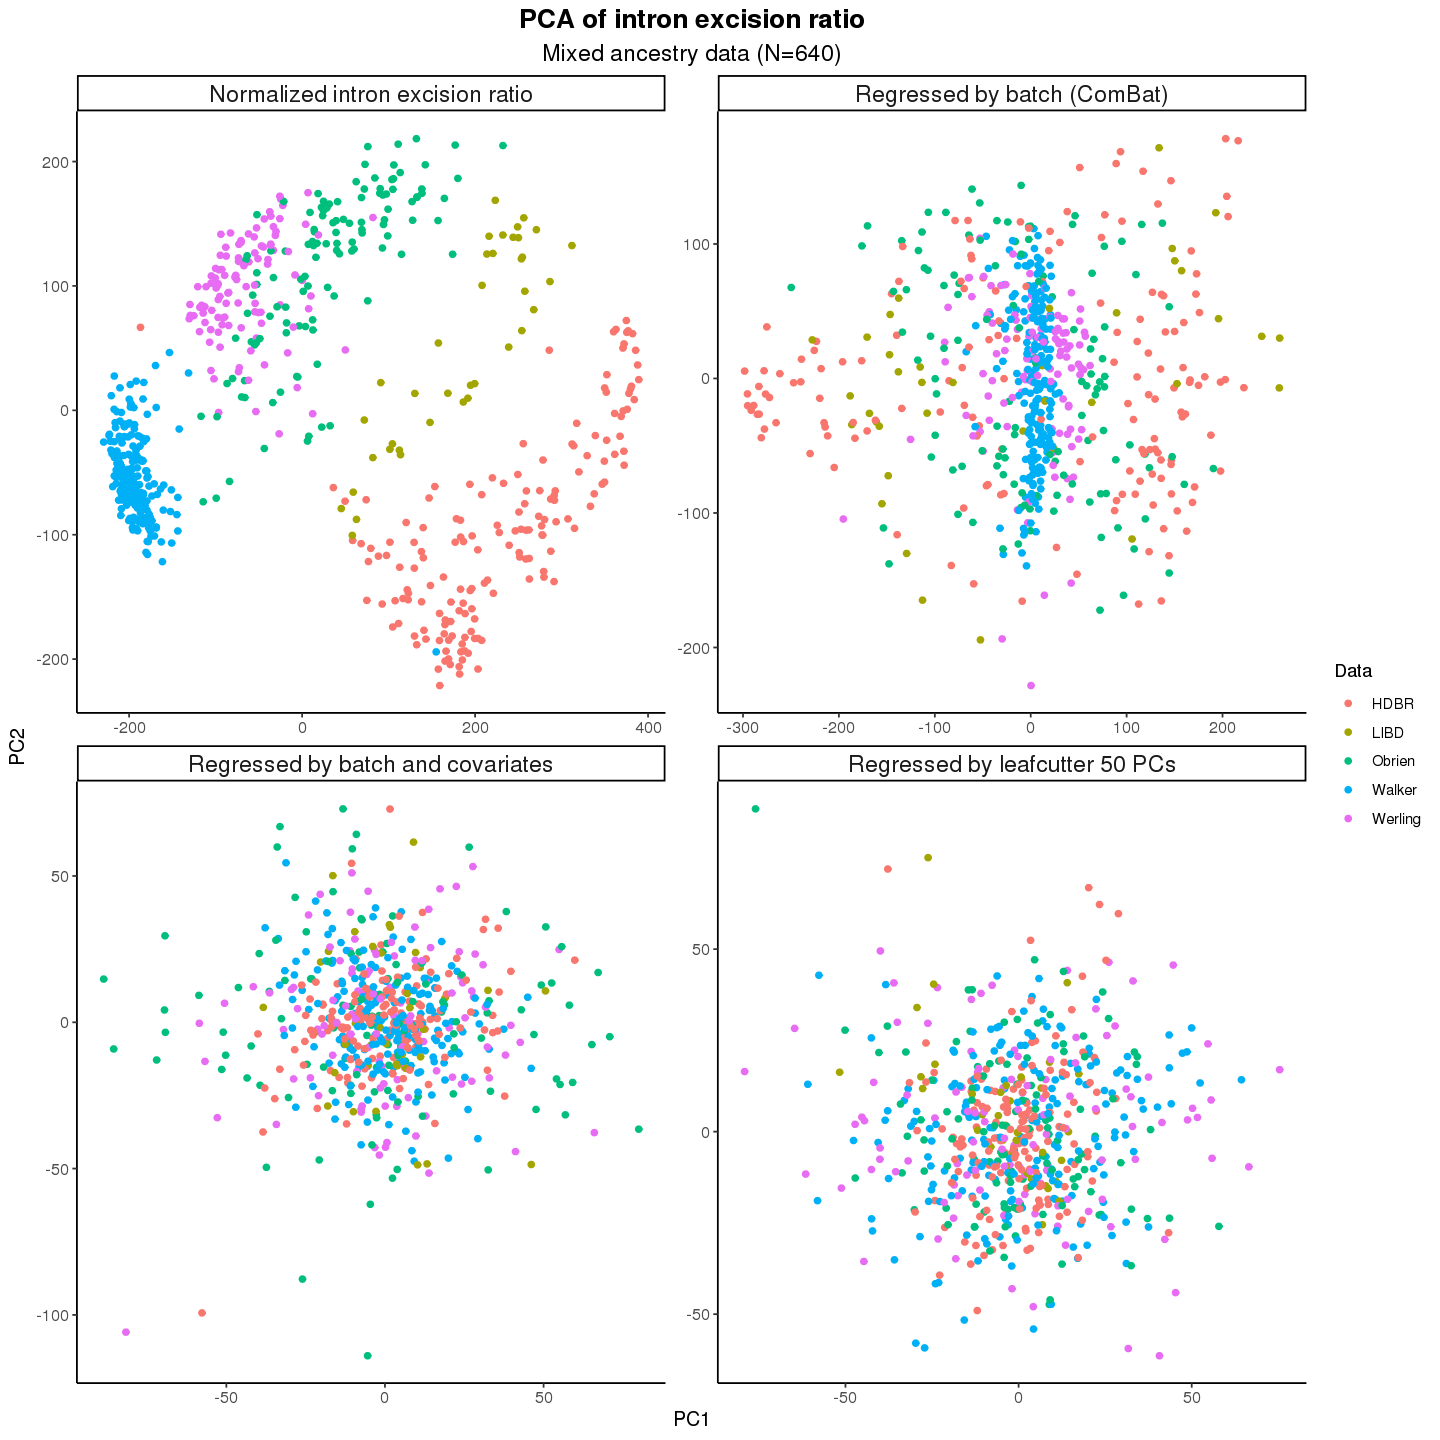

In [20]:
options(repr.plot.width=12, repr.plot.height=12)

colnames(data1) <- colnames(data2) <- colnames(data3) <- c("PC1", "PC2", "Data")
data4 <- rbind(data, data1, data2, data3)

data4$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]),
                 rep("Regressed by leafcutter 50 PCs", dim(data3)[1]))
p2 <- ggplot(data4, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "Mixed ancestry data (N=640)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

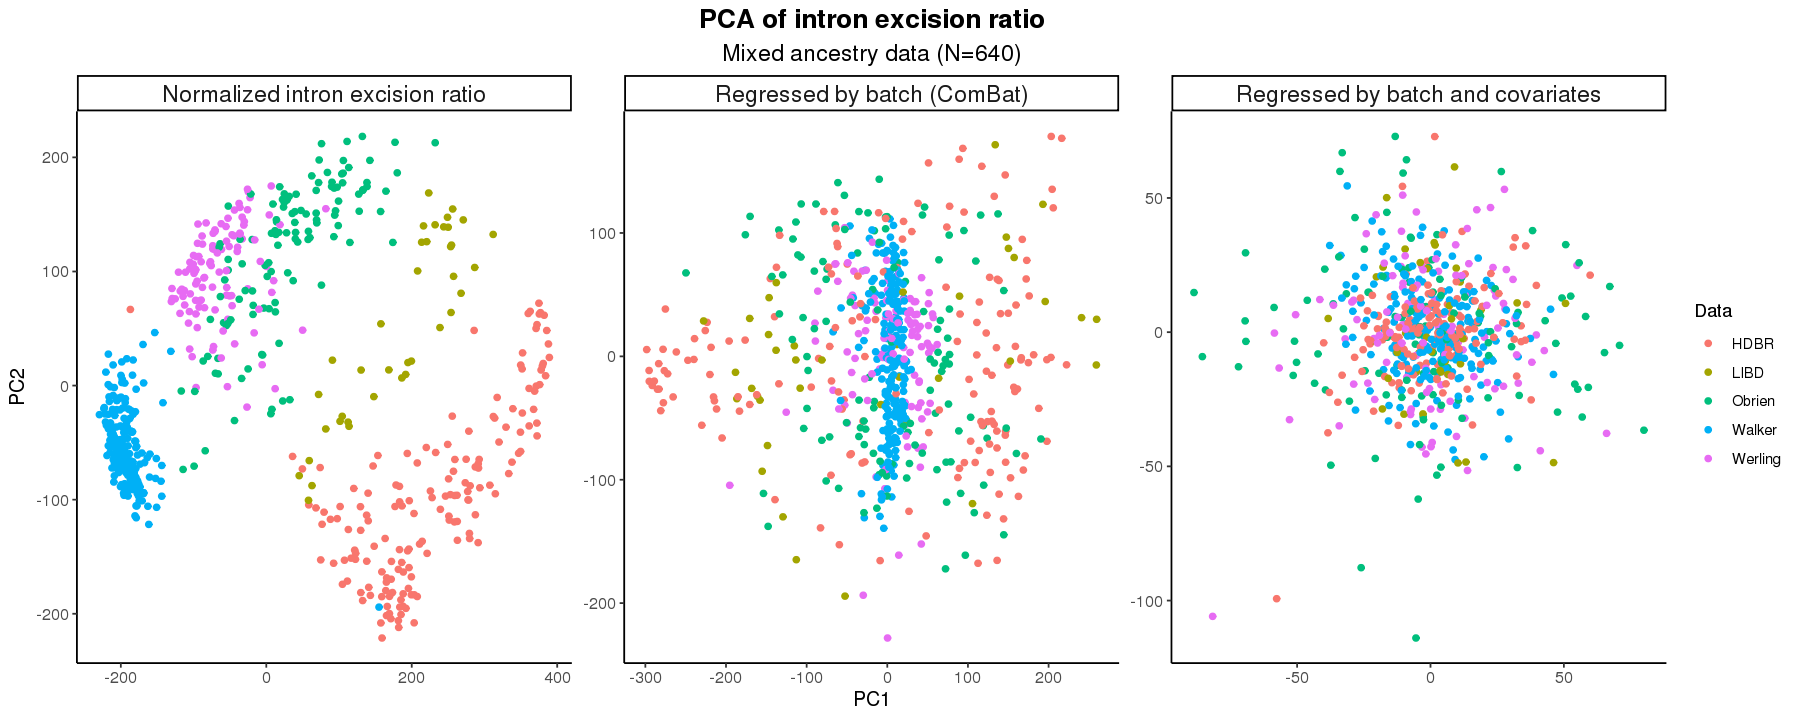

In [21]:
options(repr.plot.width=15, repr.plot.height=6)

# colnames(data1) <- colnames(data2) <- colnames(data3) <- c("PC1", "PC2", "Data")
data5 <- rbind(data, data1, data2)

data5$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))
p3 <- ggplot(data5, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "Mixed ancestry data (N=640)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

In [24]:
ggsave("figures/mixed_regress.png", p3, width = 15, height = 6)

In [23]:
dim(data5)

[1] 1920    4

In [27]:
head(cov)

,,PC1,PC2,PC3,PC4,PC5,sex,HCP1,HCP2,HCP3,⋯,HCP27,HCP28,HCP29,HCP30,HCP31,HCP32,HCP33,HCP34,HCP35,age
Br2410,1,0.01344980,-0.02610840,-6.26668e-03,0.01444480,-0.01536510,1,-1.0899027,0.2343118,-0.002978732,⋯,-1.9708288,-0.12982464,1.804111941,-0.6850380,1.22676485,-0.25235652,1.6044135,1.27930623,-0.1674352,-0.5178080
1513,1,0.00883737,-0.00241496,-2.15570e-02,-0.02663020,-0.00174134,1,0.5092700,-0.3966774,0.164835132,⋯,0.3749039,0.60515987,0.004690139,-0.1790185,0.40401712,0.10528730,0.4682255,-0.05811266,-0.9977343,-0.4602740
RNAID1940,1,0.01056460,0.01120170,-2.68095e-03,0.01161050,-0.00695816,1,1.3208361,-1.2604583,-0.019609630,⋯,-0.5510524,-0.77983438,-0.203474136,-0.5491220,0.48420429,-0.42045993,-0.4434456,0.81208853,-0.2590981,-0.3835616
RNAID1946,1,-0.01000420,0.01293590,-4.52633e-05,0.00637793,-0.00397614,0,-0.8367998,0.7210962,0.328804668,⋯,0.2075349,0.49706966,0.418585514,0.1115832,-0.74361043,-0.63317319,0.1061155,0.22301328,0.4524805,-0.4602740
Br1800,1,-0.02641560,-0.00285026,-1.01463e-03,0.00137324,-0.00378136,1,-0.3387075,-0.3067902,-0.494756921,⋯,0.3113263,-0.03765041,-0.286477580,-0.3186581,0.01077955,-0.99764060,0.4786859,-0.53603109,0.1514625,-0.4219180
11237,1,0.00964951,-0.02046210,-5.14834e-03,0.02145450,0.06687380,1,-0.6404065,-0.2678533,-0.718940176,⋯,0.1198394,-0.89599246,-0.142098130,0.6128147,0.74346317,0.02027177,0.2056952,-0.14787730,-0.8663064,-0.6136986


### Figure out what's going on with Obrien data. Try regressing without HCPs

In [26]:
cov_no_hidden <- cov[,!substring(colnames(cov), 1, 3) == "HCP"]
head(cov_no_hidden)
dim(cov_no_hidden)

,,PC1,PC2,PC3,PC4,PC5,sex,age
Br2410,1,0.01344980,-0.02610840,-6.26668e-03,0.01444480,-0.01536510,1,-0.5178080
1513,1,0.00883737,-0.00241496,-2.15570e-02,-0.02663020,-0.00174134,1,-0.4602740
RNAID1940,1,0.01056460,0.01120170,-2.68095e-03,0.01161050,-0.00695816,1,-0.3835616
RNAID1946,1,-0.01000420,0.01293590,-4.52633e-05,0.00637793,-0.00397614,0,-0.4602740
Br1800,1,-0.02641560,-0.00285026,-1.01463e-03,0.00137324,-0.00378136,1,-0.4219180
11237,1,0.00964951,-0.02046210,-5.14834e-03,0.02145450,0.06687380,1,-0.6136986


[1] 640   8

In [28]:
Y <- as.matrix(datExpr)
X <- as.matrix(cov_no_hidden)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed_no_hidden <- Y - t(X[,-1]  %*% beta[-1,])

s <- svd(datExpr_regressed_no_hidden - rowMeans(datExpr_regressed_no_hidden))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [29]:
head(data)
dim(data)

,PC1,PC2,Data
,<dbl>,<dbl>,<fct>
1,259.6087805,40.160483,LIBD
2,2.5912779,-34.849309,Walker
3,-24.2526893,2.712115,Walker
4,7.6058195,-67.600885,Walker
5,0.3199109,-2.843020,LIBD
6,114.9469272,75.729158,HDBR


[1] 640   3

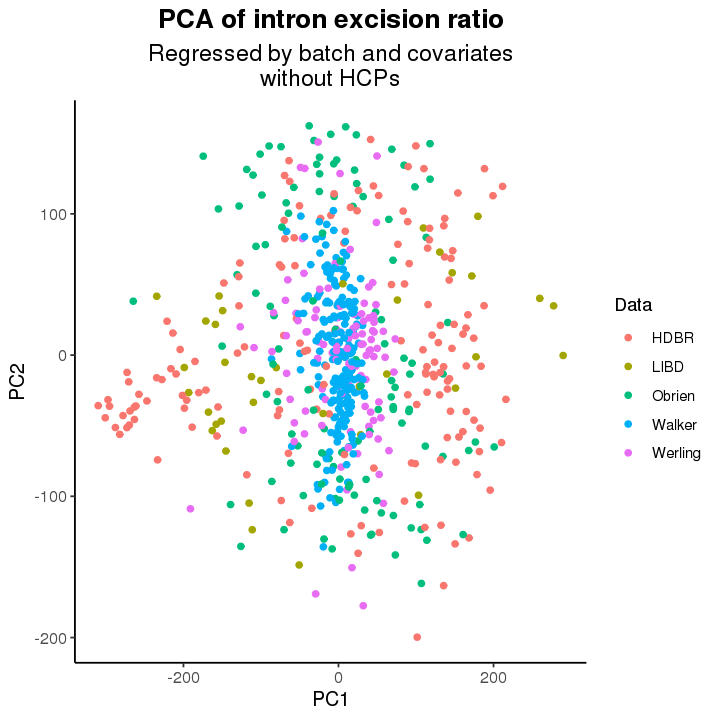

In [30]:
options(repr.plot.width=6, repr.plot.height=6)

p <- ggplot(data, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "Regressed by batch and covariates\nwithout HCPs") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p

#### EUR

In [16]:
datExpr <- fread("data/eur/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/eur/lc_combat.tsv", :
“Detected 292 column names but the data has 293 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    292

[1] 273167    288

In [17]:
datExpr_noCombat <- fread("data/eur/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/eur/lc.tsv", :
“Detected 292 column names but the data has 293 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    288

In [18]:
cov <- read.table("data/eur/25HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

[1]  32 292

[1]  32 288

In [20]:
Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [21]:
groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [22]:
# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

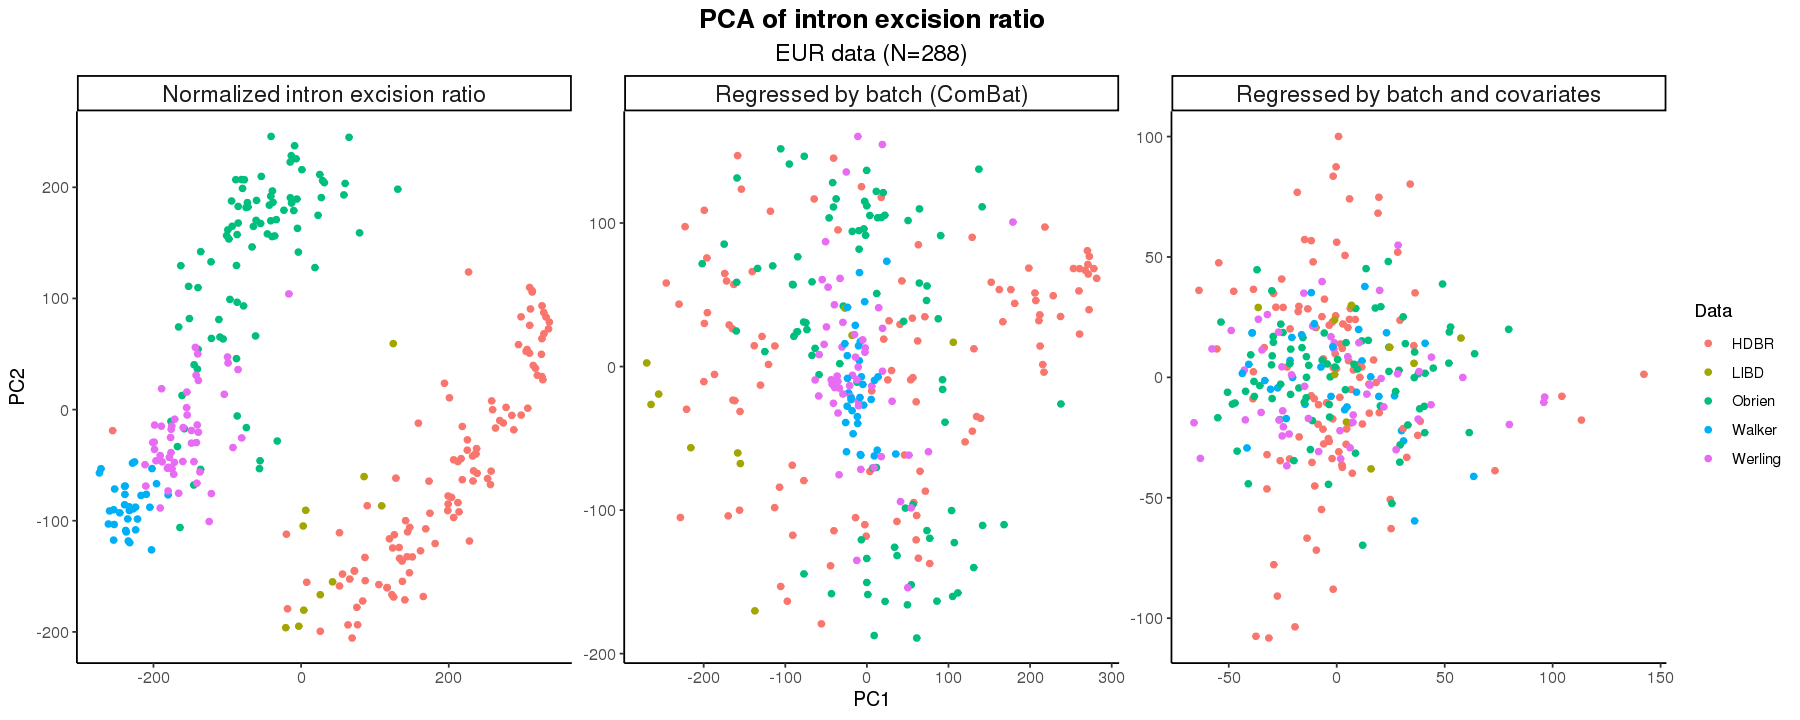

In [26]:
options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))
p3 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "EUR data (N=288)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

In [27]:
ggsave("figures/eur_regress.png", p3, width = 15, height = 6)

#### AMR

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/amr/lc_combat.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    164

[1] 273167    162

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/amr/lc.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    162

[1]  17 164

[1]  17 162

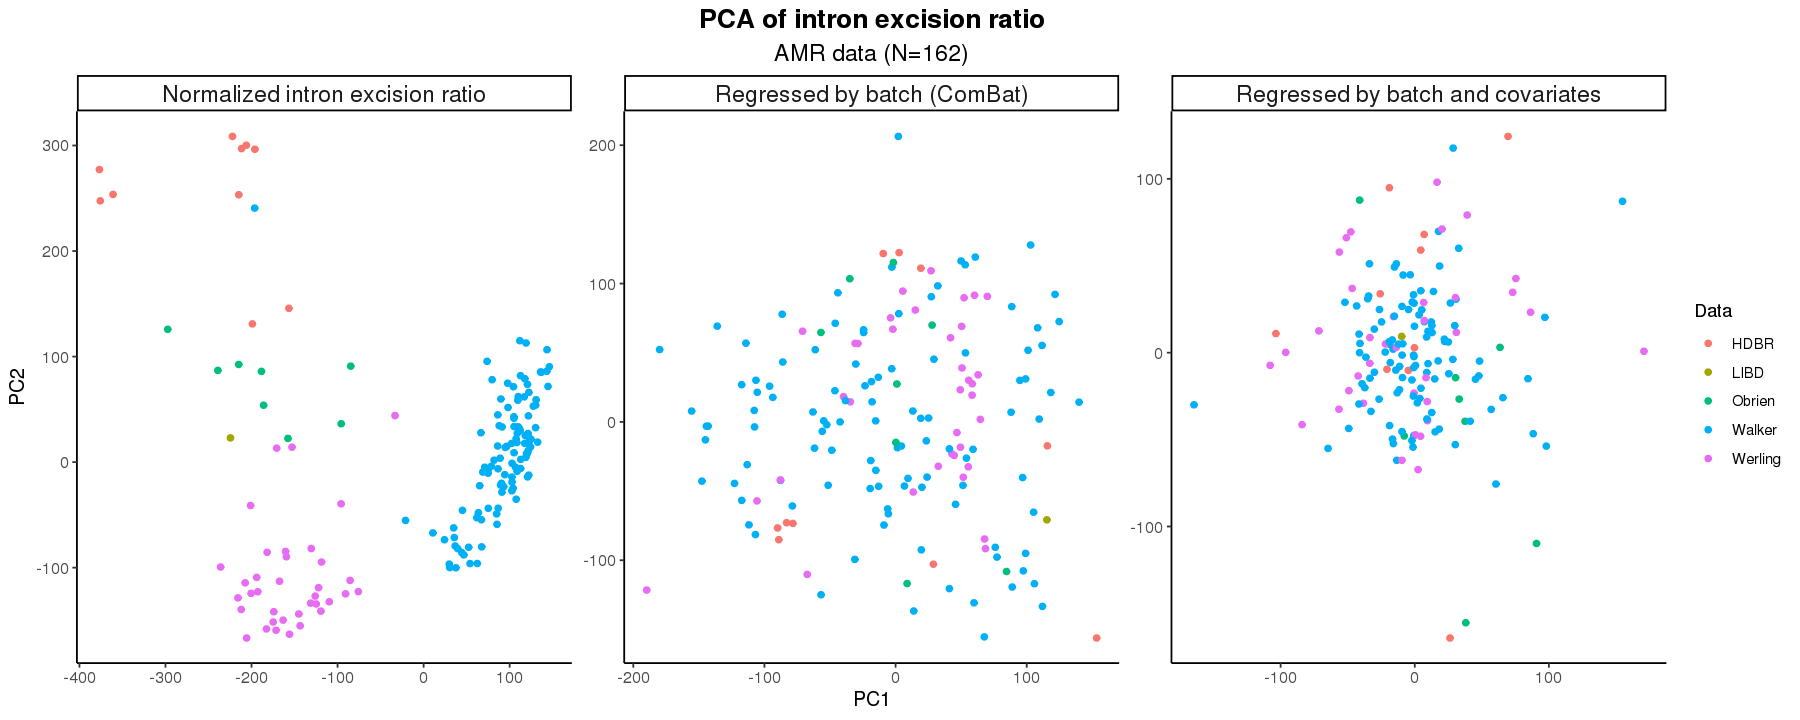

In [8]:
options(repr.plot.width=15, repr.plot.height=6)

datExpr <- fread("data/amr/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

datExpr_noCombat <- fread("data/amr/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

cov <- read.table("data/amr/10HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))
p3 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "AMR data (N=162)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

In [9]:
ggsave("figures/amr_regress.png", p3, width = 15, height = 6)

#### AFR

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/afr/lc_combat.tsv", :
“Detected 145 column names but the data has 146 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    145

[1] 273167    137

Warning message in fread("~/project-gandalm/isoform_twas/sqtl_new/data/afr/lc.tsv", :
“Detected 145 column names but the data has 146 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    137

[1]  19 145

[1]  19 137

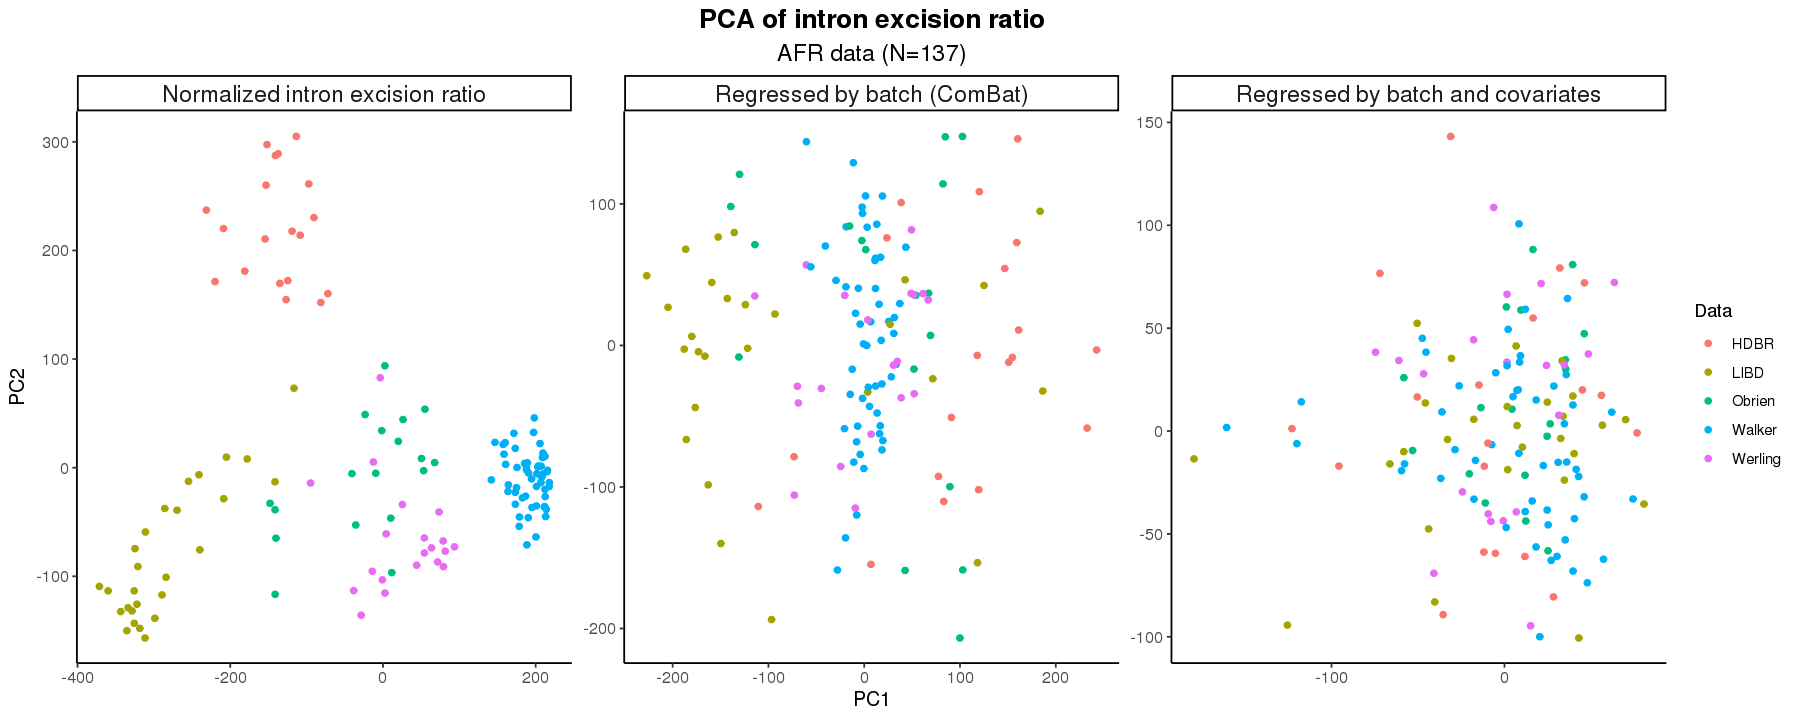

In [10]:
options(repr.plot.width=15, repr.plot.height=6)

datExpr <- fread("data/afr/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

datExpr_noCombat <- fread("data/afr/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

cov <- read.table("data/afr/12HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))
p3 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "AFR data (N=137)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

ggsave("figures/afr_regress.png", p3, width = 15, height = 6)

### 3: beta-approximated permutation pvalue

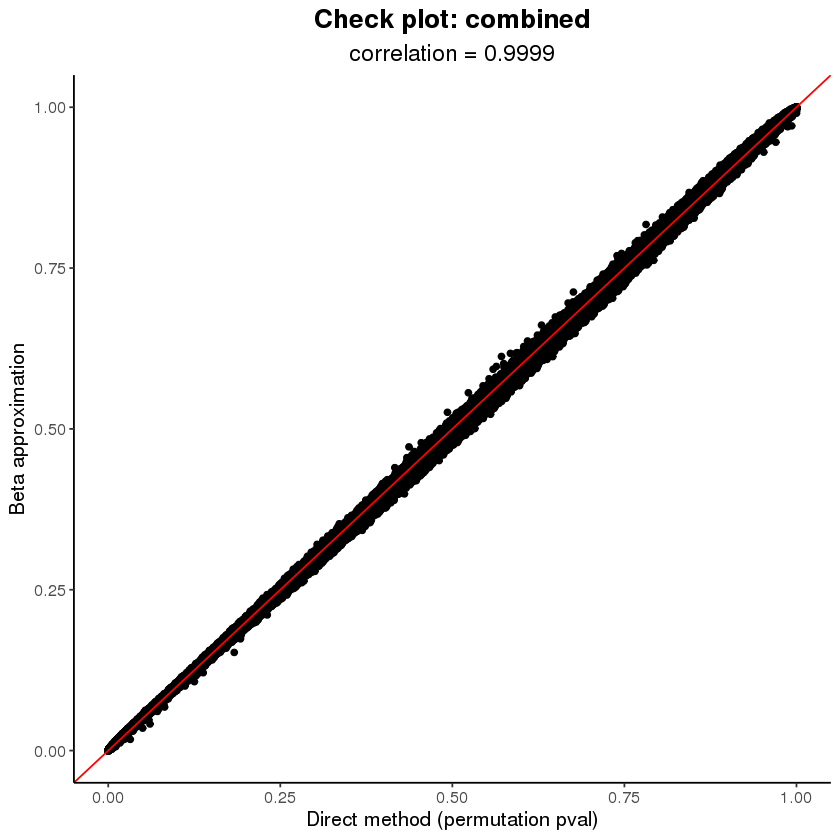

In [2]:
dat <- fread("results/mixed_perm_35hcp/all.chunks.txt.gz", data.table=F)
colnames(dat) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
dat <- dat[complete.cases(dat),]
dat <- arrange(dat, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
p <- ggplot(dat, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: combined",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/mixed_check.png", p, width = 6, height = 6)

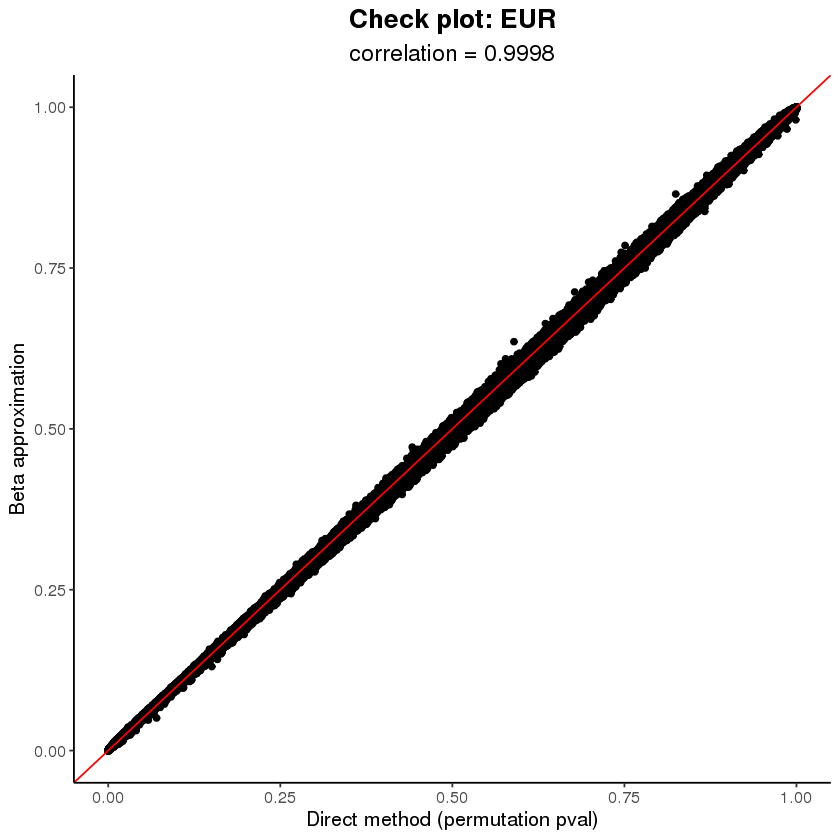

In [3]:
dat <- fread("results/eur_perm_25HCP/all.chunks.txt.gz", data.table=F)
colnames(dat) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
dat <- dat[complete.cases(dat),]
dat <- arrange(dat, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
p <- ggplot(dat, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: EUR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/eur_check.png", p, width = 6, height = 6)

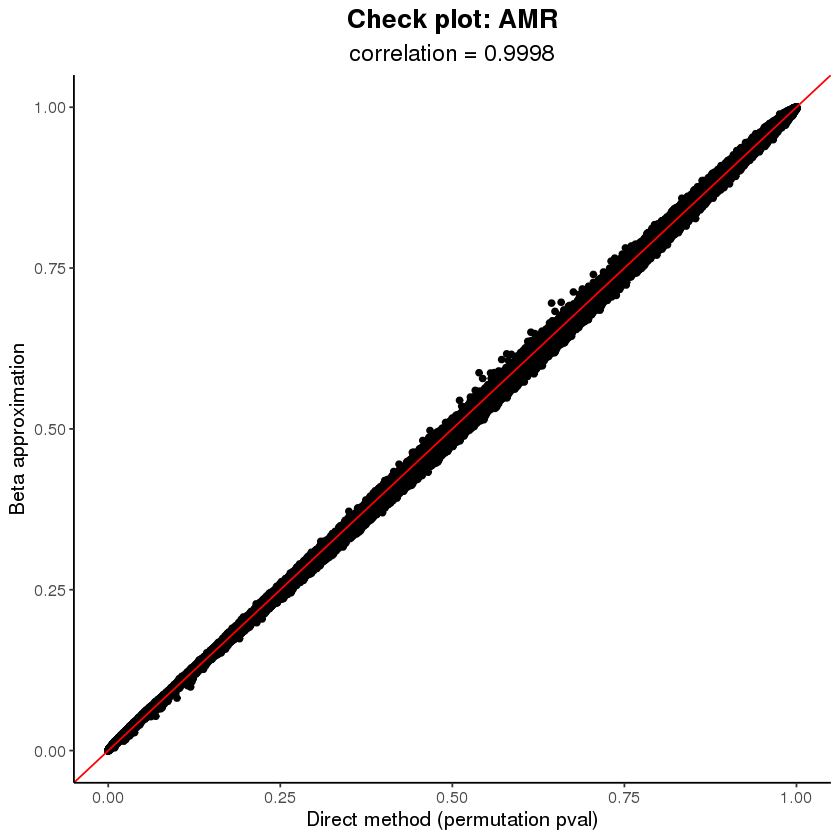

In [4]:
dat <- fread("results/amr_perm_10HCP/all.chunks.txt.gz", data.table=F)
colnames(dat) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
dat <- dat[complete.cases(dat),]
dat <- arrange(dat, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
p <- ggplot(dat, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AMR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/amr_check.png", p, width = 6, height = 6)

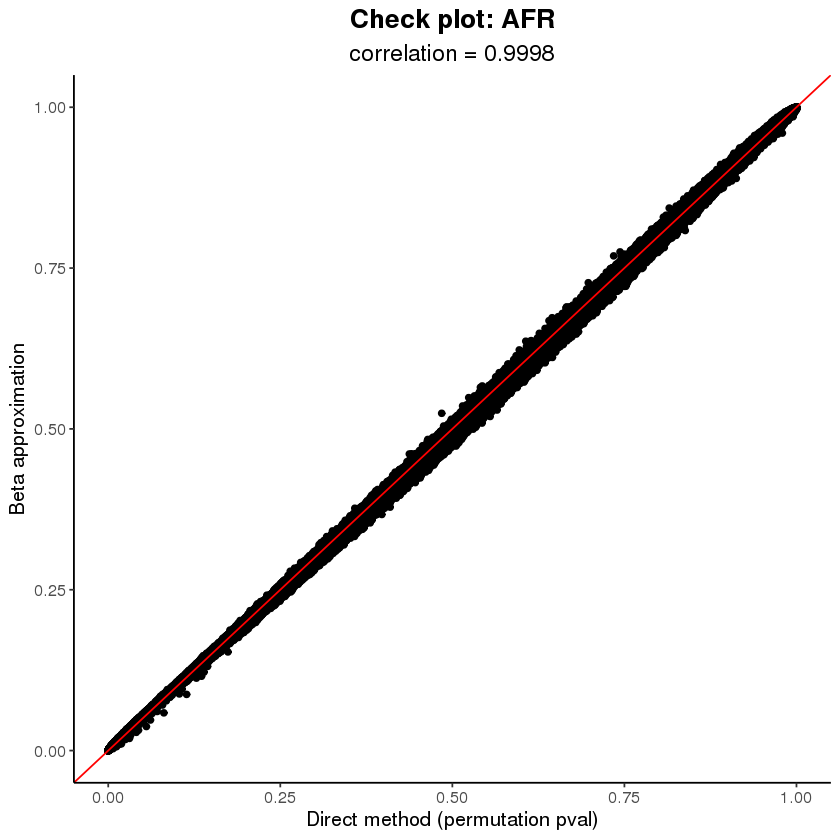

In [5]:
dat <- fread("results/afr_perm_12HCP/all.chunks.txt.gz", data.table=F)
colnames(dat) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
dat <- dat[complete.cases(dat),]
dat <- arrange(dat, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
p <- ggplot(dat, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AFR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/afr_check.png", p, width = 6, height = 6)

### 4: top sQTL distance to intron splice junction

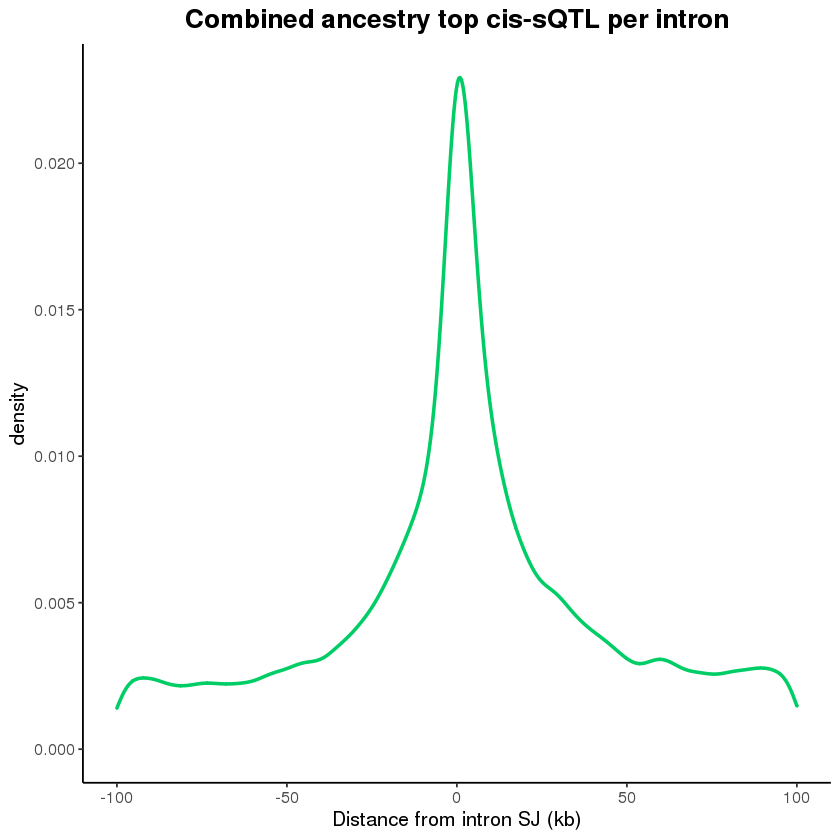

In [8]:
sig <- read.table("results/mixed_perm_35hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
sig$dist_kb <- sig$dist/1000
p <- ggplot(sig, aes(x = dist_kb)) +
    geom_density(color = "springgreen3", size = 1) + 
    labs(x = "Distance from intron SJ (kb)",
         title = "Combined ancestry top cis-sQTL per intron") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [9]:
ggsave("figures/mixed_dist.png", p, height = 6, width = 6)

In [34]:
dim(sig)
length(unique(sig$pid))
length(unique(sig$sid))

[1] 37706    14

[1] 37706

[1] 23921

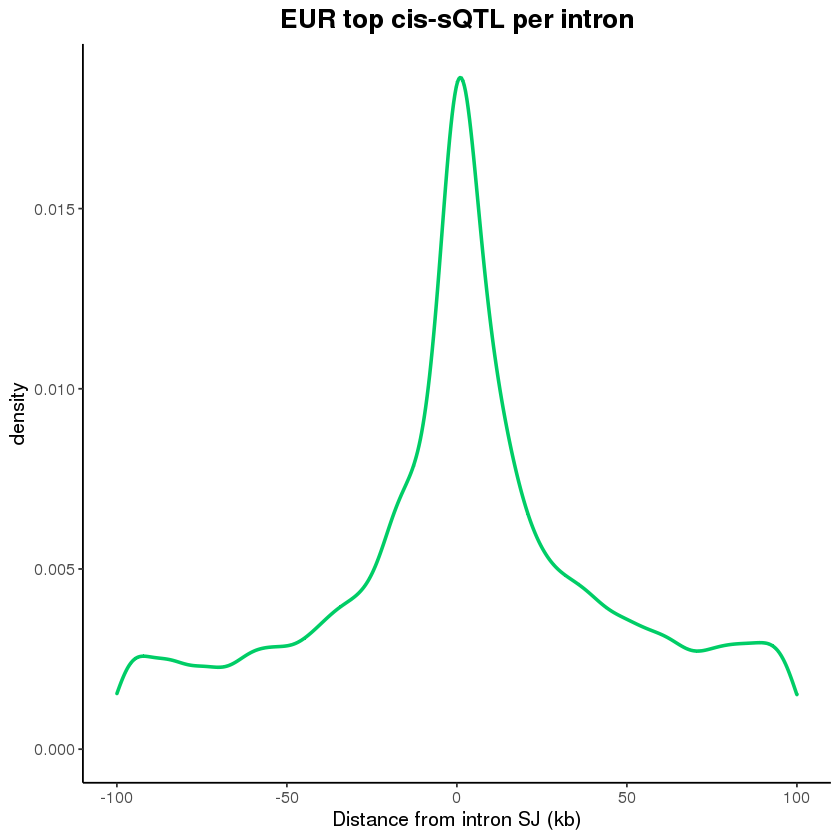

In [10]:
sig <- read.table("results/eur_perm_25HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
sig$dist_kb <- sig$dist/1000
p <- ggplot(sig, aes(x = dist_kb)) +
    geom_density(color = "springgreen3", size = 1) + 
    labs(x = "Distance from intron SJ (kb)",
         title = "EUR top cis-sQTL per intron") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [11]:
ggsave("figures/eur_dist.png", p, height = 6, width = 6)

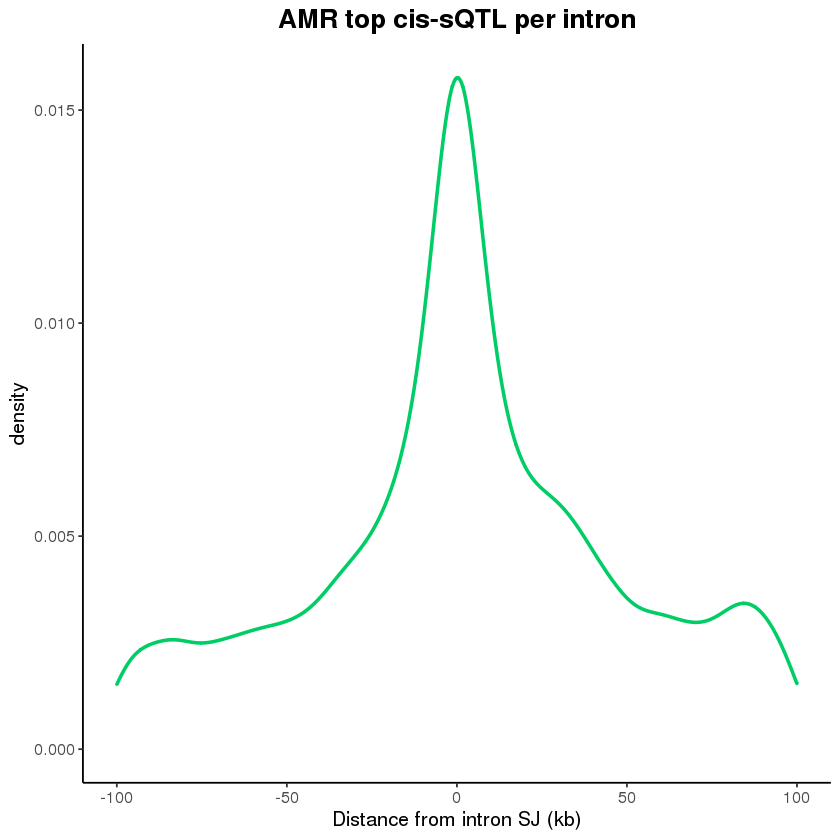

In [12]:
sig <- read.table("results/amr_perm_10HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
sig$dist_kb <- sig$dist/1000
p <- ggplot(sig, aes(x = dist_kb)) +
    geom_density(color = "springgreen3", size = 1) + 
    labs(x = "Distance from intron SJ (kb)",
         title = "AMR top cis-sQTL per intron") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/amr_dist.png", p, height = 6, width = 6)

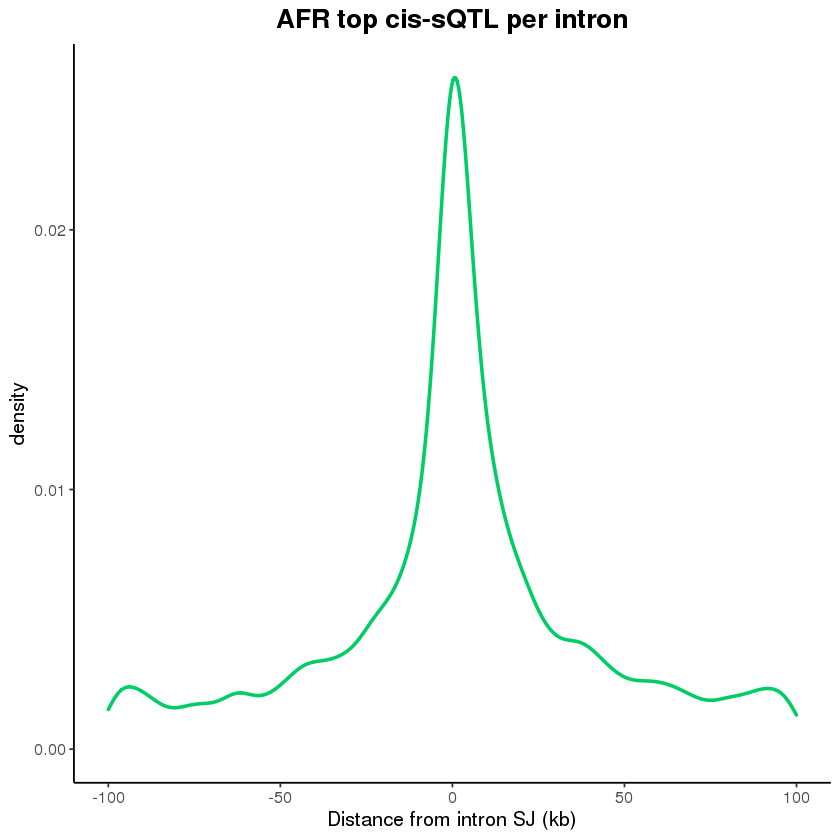

In [13]:
sig <- read.table("results/afr_perm_12HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
sig$dist_kb <- sig$dist/1000
p <- ggplot(sig, aes(x = dist_kb)) +
    geom_density(color = "springgreen3", size = 1) + 
    labs(x = "Distance from intron SJ (kb)",
         title = "AFR top cis-sQTL per intron") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p
ggsave("figures/afr_dist.png", p, height = 6, width = 6)

### 5: Map introns to genes; identify sGene

### 5-1: The GTEx way. See Snakefile rule `map_clusters_to_genes`
- Idea: for each intron, match it to exons by 3' or 5' position; then map intron clusters to all the genes that introns in this cluster can map to; one cluster can map to multiple genes
- In this way 71,429 out of 105,700 clusters mapped to some genes; 5,132 clusters mapped to more than 1 gene

In [40]:
exons_table <- fread("leafviz_annot/gencode_v33lift37_all_exons.txt.gz", data.table = F)
dim(exons_table)
head(exons_table)

[1] 1379814       5

,chr,start,end,strand,gene_name
,<chr>,<int>,<int>,<chr>,<chr>
1,chr17,40475053,40475643,-,STAT3
2,chr17,40476729,40476864,-,STAT3
3,chr17,40476981,40477079,-,STAT3
4,chr2,105049895,105050981,+,LINC01102
5,chr2,105122324,105122761,+,LINC01102
6,chr2,105123690,105123864,+,LINC01102


In [41]:
intron_counts <- fread("cluster/leafcutter_perind.counts.gz", data.table = F)

In [42]:
dim(intron_counts)
head(intron_counts)

[1] 502571    655

,chrom,Br2410.STARAligned.sortedByCoord.WASPfiltered.out.bam,1513.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1940.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1946.STARAligned.sortedByCoord.WASPfiltered.out.bam,Br1800.STARAligned.sortedByCoord.WASPfiltered.out.bam,11237.STARAligned.sortedByCoord.WASPfiltered.out.bam,18015.STARAligned.sortedByCoord.WASPfiltered.out.bam,11149.STARAligned.sortedByCoord.WASPfiltered.out.bam,1821.STARAligned.sortedByCoord.WASPfiltered.out.bam,⋯,11397.STARAligned.sortedByCoord.WASPfiltered.out.bam,11880.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1951.STARAligned.sortedByCoord.WASPfiltered.out.bam,15240.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1907.STARAligned.sortedByCoord.WASPfiltered.out.bam,1733.STARAligned.sortedByCoord.WASPfiltered.out.bam,11793.STARAligned.sortedByCoord.WASPfiltered.out.bam,11451.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1944.STARAligned.sortedByCoord.WASPfiltered.out.bam,1746.STARAligned.sortedByCoord.WASPfiltered.out.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr2:28307:31216:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
2,chr2:28307:31857:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
3,chr2:28307:45490:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
4,chr2:28307:50703:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0
5,chr2:28307:81451:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
6,chr2:37649:37743:clu_2_NA,0/0,0/0,1/1,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [43]:
introns <- intron_counts$chrom
intron_meta <- do.call(rbind, strsplit(introns,":"))
colnames(intron_meta) <- c("chr","start","end","clu")
intron_meta <- as.data.frame(intron_meta, stringsAsFactors=FALSE)
intron_meta$start <- as.numeric(intron_meta$start)
intron_meta$end <- as.numeric(intron_meta$end)

head(intron_meta)

,chr,start,end,clu
,<chr>,<dbl>,<dbl>,<chr>
1,chr2,28307,31216,clu_1_NA
2,chr2,28307,31857,clu_1_NA
3,chr2,28307,45490,clu_1_NA
4,chr2,28307,50703,clu_1_NA
5,chr2,28307,81451,clu_1_NA
6,chr2,37649,37743,clu_2_NA


In [47]:
chr <- "chr22"

In [48]:
intron_chr <- intron_meta[ intron_meta$chr==chr, ]
dim(intron_chr)
exons_chr <- exons_table[exons_table$chr==chr, ]
dim(exons_chr)

[1] 11777     4

[1] 29775     5

In [49]:
exons_chr$temp <- exons_chr$start
intron_chr$temp <- intron_chr$end
three_prime_matches <- inner_join( intron_chr, exons_chr, by="temp")

exons_chr$temp <- exons_chr$end
intron_chr$temp <- intron_chr$start
five_prime_matches <- inner_join( intron_chr, exons_chr, by="temp")

In [50]:
head(three_prime_matches)
dim(three_prime_matches)

,chr.x,start.x,end.x,clu,temp,chr.y,start.y,end.y,strand,gene_name
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
1,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
2,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
3,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
4,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
5,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
6,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9


[1] 28379    10

In [51]:
all_matches <- rbind(three_prime_matches, five_prime_matches)[ , c("clu", "gene_name")]

In [52]:
dim(all_matches)

[1] 57335     2

In [53]:
all_matches <- all_matches[!duplicated(all_matches),]
dim(all_matches)

[1] 1832    2

In [54]:
length(unique(all_matches$clu))

[1] 1625

In [2]:
res <- fread("leafviz_annot/leafcutter_clusters_to_genes.txt", data.table = F)

In [3]:
head(res)

,clu,genes
,<chr>,<chr>
1,chr1:clu_10000_NA,BSDC1
2,chr1:clu_10001_NA,FAM167B
3,chr1:clu_10003_NA,MTMR9LP
4,chr1:clu_10004_NA,LCK
5,chr1:clu_10005_NA,LCK
6,chr1:clu_10006_NA,LCK


In [4]:
dim(res)
length(unique(res$clu))

[1] 71429     2

[1] 71429

In [5]:
sum(grepl(",", res$genes))

[1] 5132

In [6]:
head(res[grepl(",", res$genes),])

,clu,genes
,<chr>,<chr>
18,chr1:clu_10032_NA,"AL033529.1,ZBTB8B"
19,chr1:clu_10034_NA,"ZBTB8A,AL033529.1"
60,chr1:clu_10110_NA,"PHC2,A3GALT2"
106,chr1:clu_10166_NA,"SMIM12,AL121988.1"
111,chr1:clu_10173_NA,"TMEM35B,AC114490.3,AC114490.2,ZMYM6"
112,chr1:clu_10174_NA,"ZMYM6,AC114490.2"


### 5-2: Leafviz way
See Snakefile rule `annotate_intron` and `summarise_annot`.